In [1]:
#TODO czy zapisywać Logging interval ? 
#TODO i czy zapisywać całkowity number of epochs gdyby we wczytanym modelu robić kolejnego checkpointa
from data_helper import get_dataloaders_and_standarscaler_photons, get_dataloaders_and_standarscaler_photons_from_numpy
from train_helper import train_vae
from plot_helper import plot_training_loss
from models_architecture_helper import VAE_Linear_0103

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import time
import seaborn as sns

# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

In [2]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 10000
NUM_EPOCHS = 20
LOGGING_INTERVAL=300
RECONSTRUCTION_TERM_WEIGHT=1.5
SAVE_MODEL_FILE='checkpoint_0103.pth'
path='/data1/dose-3d-generative/data/training-data/DISP_0.5_ANGLE_0/NUMPY/a1_10_7.npy'

In [3]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [4]:
print(torch.cuda.memory_allocated(device=DEVICE))
print(torch.cuda.memory_cached(device=DEVICE))

0
0


/opt/anaconda/anaconda3/envs/generative/lib/python3.9/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [5]:
# #ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
# photons = np.load(path)
# X = np.zeros(photons.shape,dtype=np.float32)
# np.copyto(X,photons)

In [6]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros((10000001, 6),dtype=np.float32)
np.copyto(X,photons[:,:-1])
print(X.shape)

(10000001, 6)


In [7]:
X_reflection=copy.deepcopy(X)
X_reflection[:,2]=-X_reflection[:,2]
X_reflection[:,4]=-X_reflection[:,4]

X_sum=np.concatenate((X,X_reflection),axis=0)
print(len(X_sum))

20000002


In [8]:
df_data = pd.DataFrame(X_sum, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.77526,-0.50856,-4.60704,-0.018979,-0.177872,0.983871
1,0.77526,-0.77813,-5.10840,-0.029292,-0.196501,0.980066
2,0.45010,-3.74409,-1.33591,-0.145330,-0.051869,0.988023
3,0.39630,-2.50916,-3.30103,-0.274393,-0.273584,0.921879
4,0.45010,-4.79711,-1.70242,-0.184824,-0.065606,0.980579


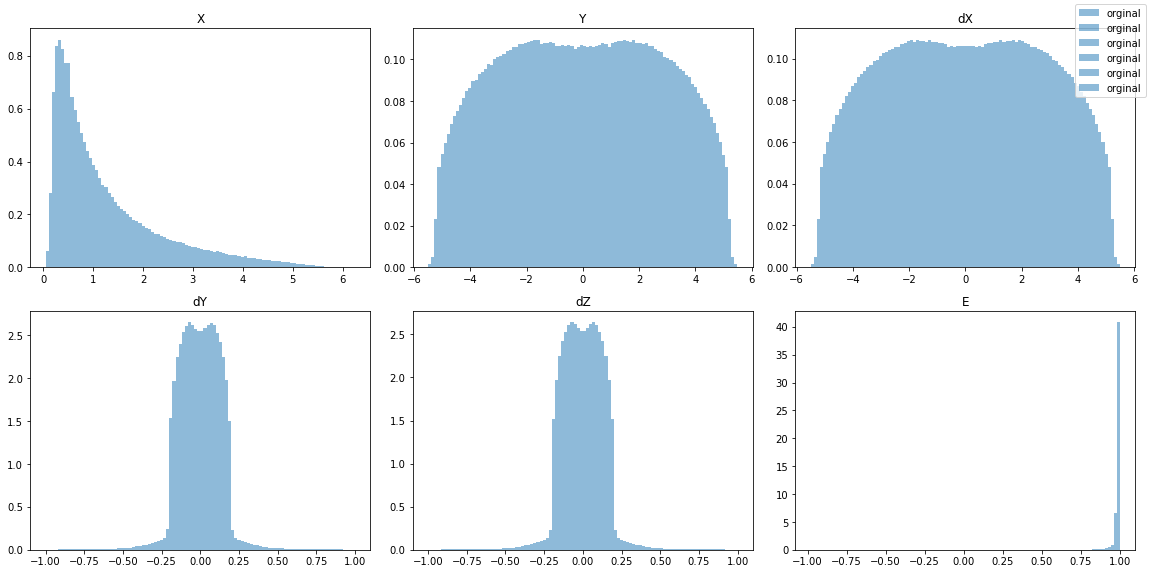

In [9]:
tmp_check=df_data.to_numpy(dtype=np.float32)
orginal_check=copy.deepcopy(tmp_check)

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal_check[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal_check[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal_check[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal_check[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal_check[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal_check[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
# axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

In [10]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons_from_numpy(tmp_X=X_sum,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.4, 
    validation_fraction=0.0)

In [11]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test


torch.Size([10000, 6])


In [12]:
# #MODEL NASZEJ SIECI 13->13->7->3
# class VAE_Linear(nn.Module):
#     def __init__(self):
#         super().__init__()        
#         self.encoder = nn.Sequential(
#             nn.Linear(6, 5),
#             #nn.BatchNorm1d(5),
#             nn.ReLU(),
#             # nn.Linear(5, 4),
#             nn.BatchNorm1d(5),
#             torch.nn.Linear(5,4),
#             nn.BatchNorm1d(4),
#             nn.ReLU(),
#             # nn.ReLU(),
#         )

#         self.z_mean=nn.Sequential(
#             # torch.nn.Linear(4,3),
#             # nn.BatchNorm1d(3),
#             # nn.ReLU(),
#             nn.Linear(4,3)
#             )

#         self.z_log_var=nn.Sequential(
#             # torch.nn.Linear(4,3),
#             # nn.BatchNorm1d(3),
#             # nn.ReLU(),
#             nn.Linear(4,3)
#             )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(3,4),
#             nn.ReLU(),
#             nn.BatchNorm1d(4),
#             nn.Linear(4, 5),
#             nn.ReLU(),
#             nn.BatchNorm1d(5),
#             # nn.Linear(4,5),
#             # nn.ReLU(),
#             #nn.BatchNorm1d(5),
#             nn.Linear(5,6)
            
#            # nn.Sigmoid()
#         )
#     def reparameterize(self, z_mu, z_log_var):
#         eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())#get_device dziala tylko dla tensoróœ z gpu
#         z = z_mu + eps * torch.exp(z_log_var/2.) 
#         return z

#     def reparameterize_for_cpu(self, z_mu, z_log_var):
#         eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu')#get_device dziala tylko dla tensoróœ z gpu
#         z = z_mu + eps * torch.exp(z_log_var/2.) 
#         return z

#     def forward(self, x):
#         x = self.encoder(x)
#         z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
#         encoded = self.reparameterize_for_cpu(z_mean, z_log_var)
#         decoded = self.decoder(encoded)
#         return encoded, z_mean, z_log_var, decoded

In [13]:
model = VAE_Linear_0103()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, 
                             weight_decay=1e-5)

In [14]:
log_dict=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE)

Epoch: 001/020 | Batch 0000/1200 | Loss: 9.8906
Epoch: 001/020 | Batch 0300/1200 | Loss: 9.5531
Epoch: 001/020 | Batch 0600/1200 | Loss: 7.8123
Epoch: 001/020 | Batch 0900/1200 | Loss: 7.2900
***Epoch: 001/020 | Loss: 4.074
Test***Epoch: 001/020 | Loss: 4.078
Time elapsed: 7.61 min
Epoch: 002/020 | Batch 0000/1200 | Loss: 7.0697
Epoch: 002/020 | Batch 0300/1200 | Loss: 6.9310
Epoch: 002/020 | Batch 0600/1200 | Loss: 6.6843
Epoch: 002/020 | Batch 0900/1200 | Loss: 6.6423
***Epoch: 002/020 | Loss: 3.672
Test***Epoch: 002/020 | Loss: 3.675
Time elapsed: 15.63 min
Epoch: 003/020 | Batch 0000/1200 | Loss: 6.7786
Epoch: 003/020 | Batch 0300/1200 | Loss: 6.5817
Epoch: 003/020 | Batch 0600/1200 | Loss: 6.2905
Epoch: 003/020 | Batch 0900/1200 | Loss: 6.1547
***Epoch: 003/020 | Loss: 3.110
Test***Epoch: 003/020 | Loss: 3.114
Time elapsed: 23.66 min
Epoch: 004/020 | Batch 0000/1200 | Loss: 5.9877
Epoch: 004/020 | Batch 0300/1200 | Loss: 5.8538
Epoch: 004/020 | Batch 0600/1200 | Loss: 5.7053
Epoch

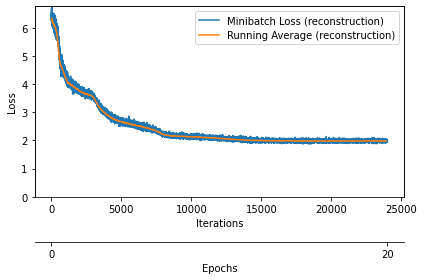

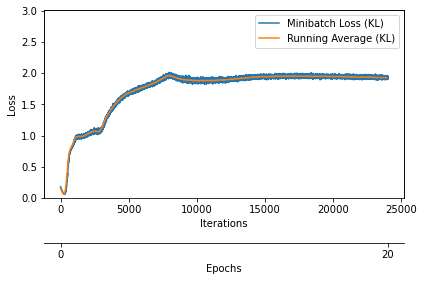

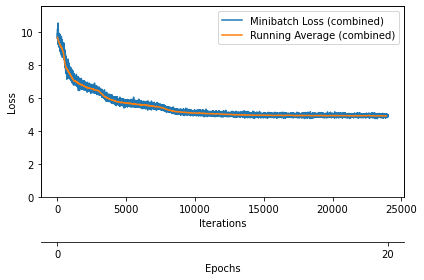

In [15]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



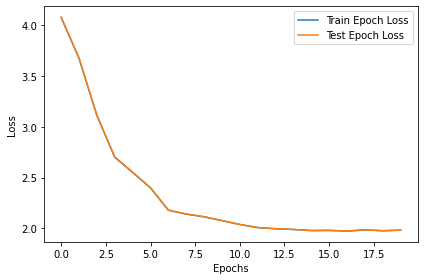

In [16]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [17]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

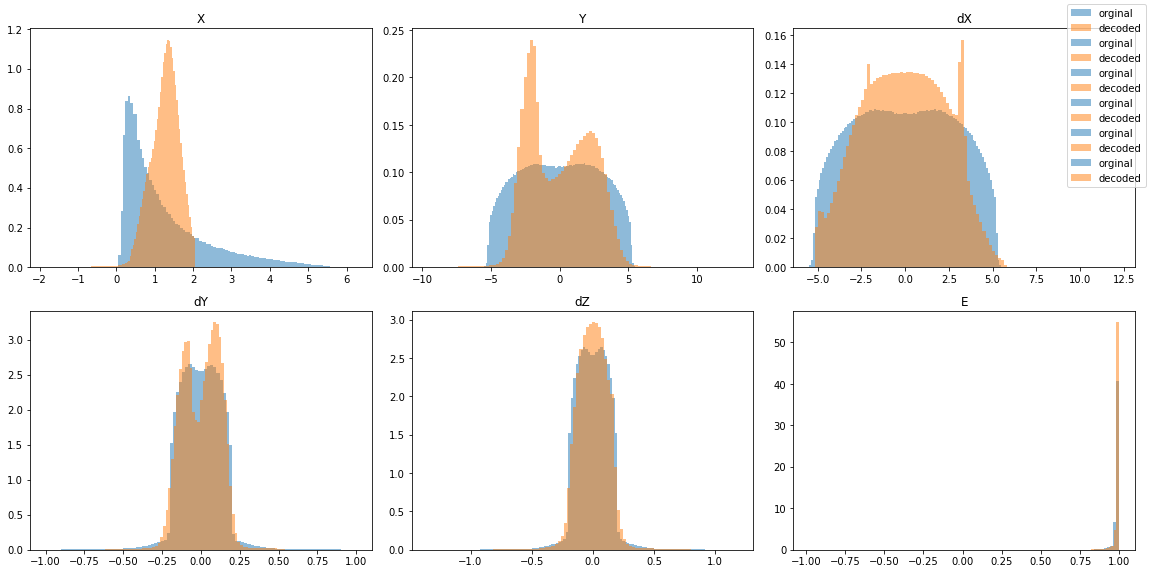

In [18]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

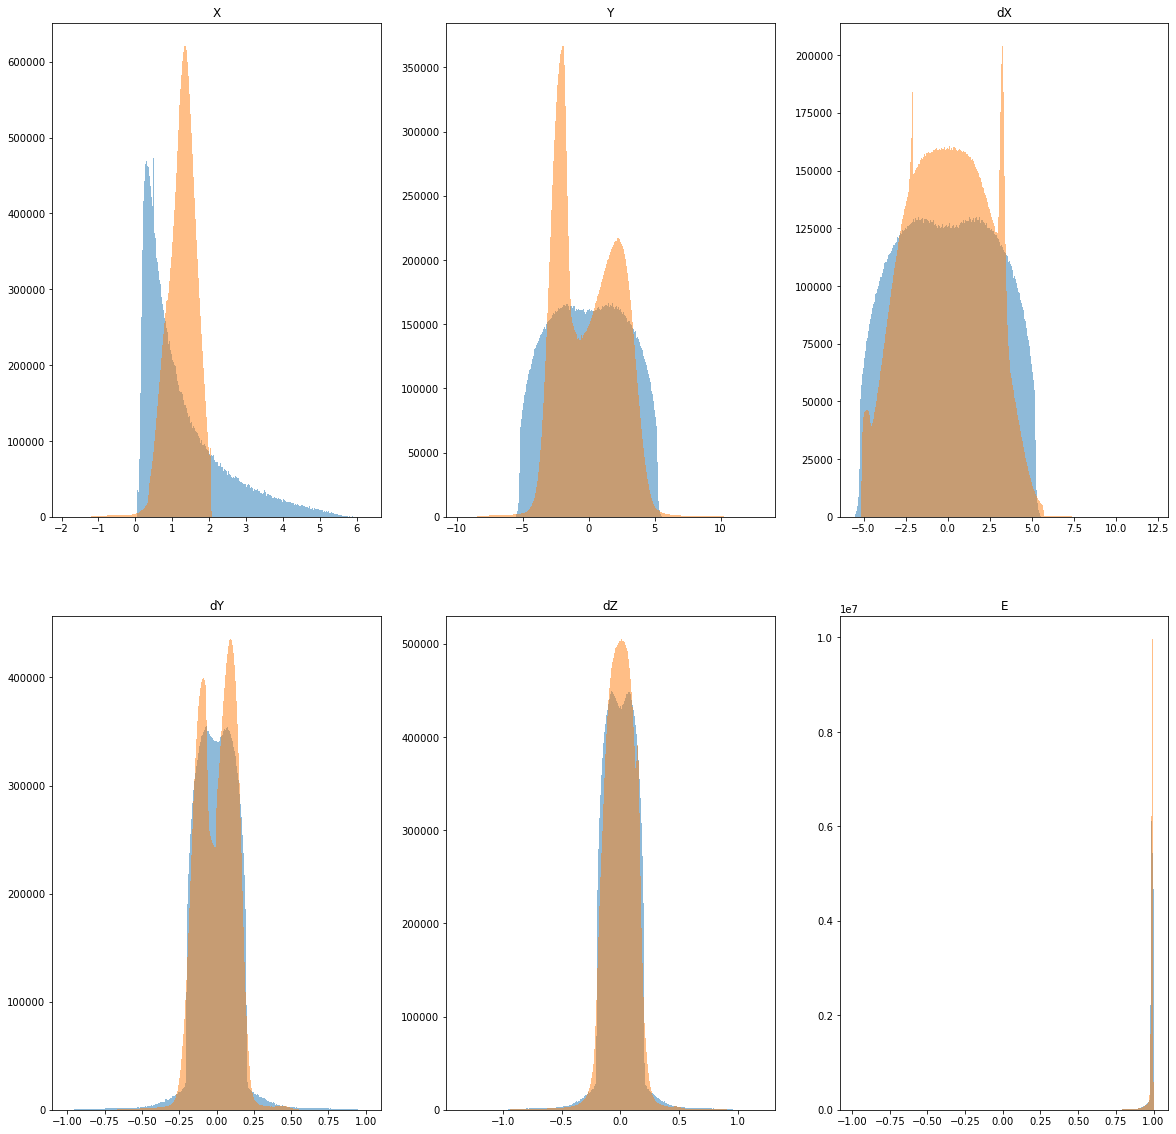

In [19]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)







In [20]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [21]:
# g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# #g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

In [22]:
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [23]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.0125, random_state=2)) 
print(sample.shape)
print(sample.head())

(500000, 7)
                 X         Y        dX        dY        dZ         E  \
31583840  1.347819  2.090588 -0.064720  0.108827 -0.011790  0.988370   
34539943  0.785791  3.182957  2.181175  0.125750  0.102404  0.979843   
20004843  1.098509  3.303272 -3.829074  0.182731 -0.174097  0.984555   
20169494  1.218360  1.777012  3.879781  0.065502  0.171902  0.984187   
38060417  0.638587 -3.816483  2.788213 -0.218675  0.189235  0.956809   

         dataset_name  
31583840      decoded  
34539943      decoded  
20004843      decoded  
20169494      decoded  
38060417      decoded  


In [24]:
sample2=orginal_df.apply(lambda x: x.sample(frac=0.0125, random_state=2)) 
print(sample2.shape)
print(sample2.head())

(250000, 6)
                X        Y       dX        dY        dZ         E
11583838  0.72217  1.91911  1.02320  0.075932  0.040737  0.996280
14539941  0.19622  2.45577  4.91175  0.094408  0.188461  0.977532
4841      0.36820  3.95641 -3.81723  0.152133 -0.146734  0.977407
169492    1.24696  4.82186 -0.47056 -0.187327  0.301854  0.934769
18060415  0.46350 -3.66491  2.14019 -0.309671  0.214503  0.926333


In [25]:
# sns.pairplot(sample2, kind="scatter")

In [26]:
sample3=decoded_df.apply(lambda x: x.sample(frac=0.0125, random_state=2)) 
print(sample3.shape)
print(sample3.head())

(250000, 6)
                 X         Y        dX        dY        dZ         E
11583838  1.347819  2.090588 -0.064720  0.108827 -0.011790  0.988370
14539941  0.785791  3.182957  2.181175  0.125750  0.102404  0.979843
4841      1.098509  3.303272 -3.829074  0.182731 -0.174097  0.984555
169492    1.218360  1.777012  3.879781  0.065502  0.171902  0.984187
18060415  0.638587 -3.816483  2.788213 -0.218675  0.189235  0.956809


In [27]:
# sns.pairplot(sample3, kind="scatter")

In [28]:
# sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [29]:
# sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [30]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [31]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [32]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.359750,2.61497,-4.698670,0.100502,-0.180584,0.978411
1,1.293775,2.13328,-2.813006,0.123186,-0.135253,0.989341


In [33]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(12000000, 3)


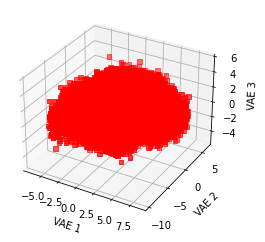

In [34]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()